In [96]:
import pandas as pd

# 加载数据
df = pd.read_json("/Users/viewyan/fairchem/src/fairchem/data/odac/force_field/data_w_oms.json")  # 请替换成你本地的路径

# 查看基本结构
print("样本总数：", len(df))
print("字段名：", df.columns.tolist())

# 查看每种 set 的分布
print(df['set'].value_counts())



样本总数： 51478
字段名： ['name', 'y', 'y_sys', 'y_mof', 'y_mol', 'id', 'set', 'path', 'oms', 'defective', 'ff']
set
train    48875
test      1391
val       1212
Name: count, dtype: int64


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# 画出 y 的分布图（DFT吸附能）
plt.figure(figsize=(6, 4))
sns.histplot(df['y'], bins=100, kde=True)
plt.title("Distribution of DFT Adsorption Energy (y)")
plt.xlabel("y (eV)")
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 600x400 with 0 Axes>

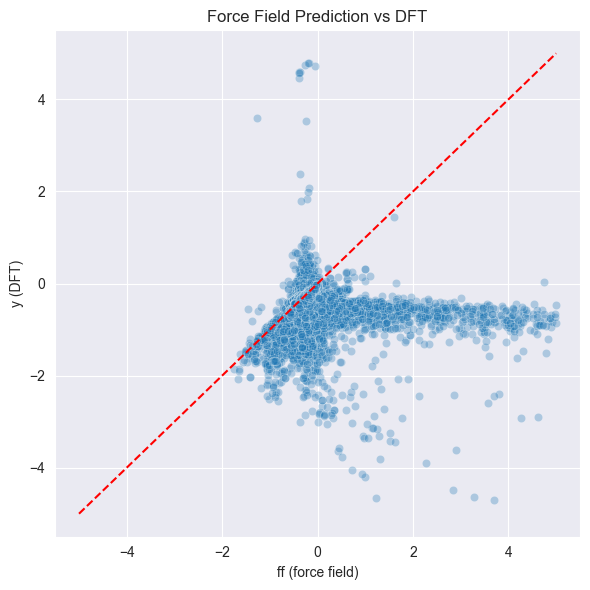

In [98]:
# 清洗掉离群值（否则图太压）
df_filtered = df[(df['ff'] < 5) & (df['ff'] > -5) & (df['y'] > -5) & (df['y'] < 5)]

# 画散点图
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_filtered, x='ff', y='y', alpha=0.3)
plt.plot([-5, 5], [-5, 5], 'r--')  # 理想线
plt.title("Force Field Prediction vs DFT")
plt.xlabel("ff (force field)")
plt.ylabel("y (DFT)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# 准备数据（只用 ff 特征）
X = df[['ff']]
y = df['y']

# 切分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型训练
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测 + 评估
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🌟 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🌟 R² Score: {r2:.4f}")

🌟 Mean Absolute Error (MAE): 0.1315
🌟 R² Score: 0.1650


In [100]:
# 用 ff, oms, defective 三个特征
X = df[['ff', 'oms', 'defective']]
y = df['y']

# 训练集划分 & 模型训练
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测 + 评估
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🌟 MAE with structure features: {mae:.4f}")
print(f"🌟 R² Score with structure features: {r2:.4f}")


🌟 MAE with structure features: 0.1290
🌟 R² Score with structure features: 0.2076


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 加载数据
df = pd.read_json("/Users/viewyan/fairchem/src/fairchem/data/odac/force_field/data_w_ml.json")

# One-hot 编码 ads
df_encoded = pd.get_dummies(df, columns=['ads'])

# 构建特征 & 标签
X = df_encoded[['ff', 'oms', 'defective', 'ads_CO2', 'ads_H2O']]
y = df_encoded['dft']  # ✅ 改成 'dft' 而不是 'y'

# 切分 & 模型
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🌟 MAE with adsorbate type: {mae:.4f}")
print(f"🌟 R² Score with adsorbate type: {r2:.4f}")


🌟 MAE with adsorbate type: 0.1447
🌟 R² Score with adsorbate type: 0.2365


In [102]:
df_super = pd.read_csv("/Users/viewyan/fairchem/src/fairchem/data/odac/supercell_info.csv")
df_merged = pd.merge(df_encoded, df_super, on="name", how="left")

# 查看有哪些新列可以选来建模
print(df_merged.columns)

Index(['dft', 'id', 'name', 'set', 'oms', 'defective', 'ml', 'ff', 'ads_CO2',
       'ads_H2O', 'Unnamed: 0', 'nco2', 'nh2o', 'nx', 'ny', 'nz'],
      dtype='object')


In [103]:
pip install -U matminer


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [104]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import SiteStatsFingerprint

# ✅ 1. 初始化 element 特征器（composition-based）
ep_feat = ElementProperty.from_preset("magpie")

# ✅ 2. 用 SiteStatsFingerprint 包一层结构级统计量
featurizer = SiteStatsFingerprint(
    ep_feat,
    stats=["mean", "geometric_mean", "std_dev", "minimum", "maximum"]
)


/Users/viewyan/PyCharmMiscProject/.venv/lib/python3.9/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [105]:
from pymatgen.core import Structure
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import StructuralHeterogeneity
from pymatgen.core.composition import Composition

import os
from tqdm import tqdm
import pandas as pd

# 初始化特征器
ep_feat = ElementProperty.from_preset("magpie",impute_nan=True)

cif_dir = "/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_structures/pristine"

data = []
for fname in tqdm(os.listdir(cif_dir)):
    if fname.endswith(".cif"):
        try:
            structure = Structure.from_file(os.path.join(cif_dir, fname))
            composition = structure.composition
            feats = ep_feat.featurize(composition)  # ✅ 注意只用 composition
            data.append([fname.replace(".cif", "")] + feats)
        except Exception as e:
            print(f"❌ {fname} failed: {e}")

# 存为 DataFrame
df = pd.DataFrame(data, columns=["mof_id"] + ep_feat.feature_labels())

  5%|▌         | 7/135 [00:00<00:02, 62.12it/s]/Users/viewyan/PyCharmMiscProject/.venv/lib/python3.9/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/Users/viewyan/PyCharmMiscProject/.venv/lib/python3.9/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
 36%|███▋      | 49/135 [00:01<00:02, 41.06it/s]/Users/viewyan/PyCharmMiscProject/.venv/lib/python3.9/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered wh

In [106]:
save_path = "/Users/viewyan/Desktop/pristine_features.csv"
df.to_csv(save_path, index=False)


In [107]:
import pandas as pd

# 加载数据
df = pd.read_csv("/Users/viewyan/Desktop/pristine_features.csv")

# 查看基本结构
print("📊 样本总数:", len(df))
print("🧱 字段名:", df.columns.tolist())

# 展示前几行看看内容长啥样
print("\n🔍 前几行数据：")
print(df.head())

# 检查是否有重复行（完全重复的整行）
duplicates = df.duplicated()
print(f"\n⚠️ 重复行数: {duplicates.sum()}")

# 如果有重复，可以列出前几条看看
if duplicates.sum() > 0:
    print("\n🔁 前几条重复样本：")
    print(df[duplicates].head())

# 也可以按 mof_id 看看是否重复
dup_ids = df['mof_id'].duplicated()
print(f"\n🔁 mof_id 重复数: {dup_ids.sum()}")

# 查找重复的列
dup_cols = df.T.duplicated()

# 显示重复的列名
duplicate_columns = df.columns[dup_cols]
print(f"🧩 重复的列数: {dup_cols.sum()}")
print("🔁 重复的列名:")
print(duplicate_columns.tolist())


📊 样本总数: 135
🧱 字段名: ['mof_id', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'MagpieData 

🧩 找到重复列数: 20
🔁 重复列名样例: ['MagpieData mode NsValence', 'MagpieData range NdValence', 'MagpieData mode NdValence', 'MagpieData minimum NfValence', 'MagpieData range NfValence']


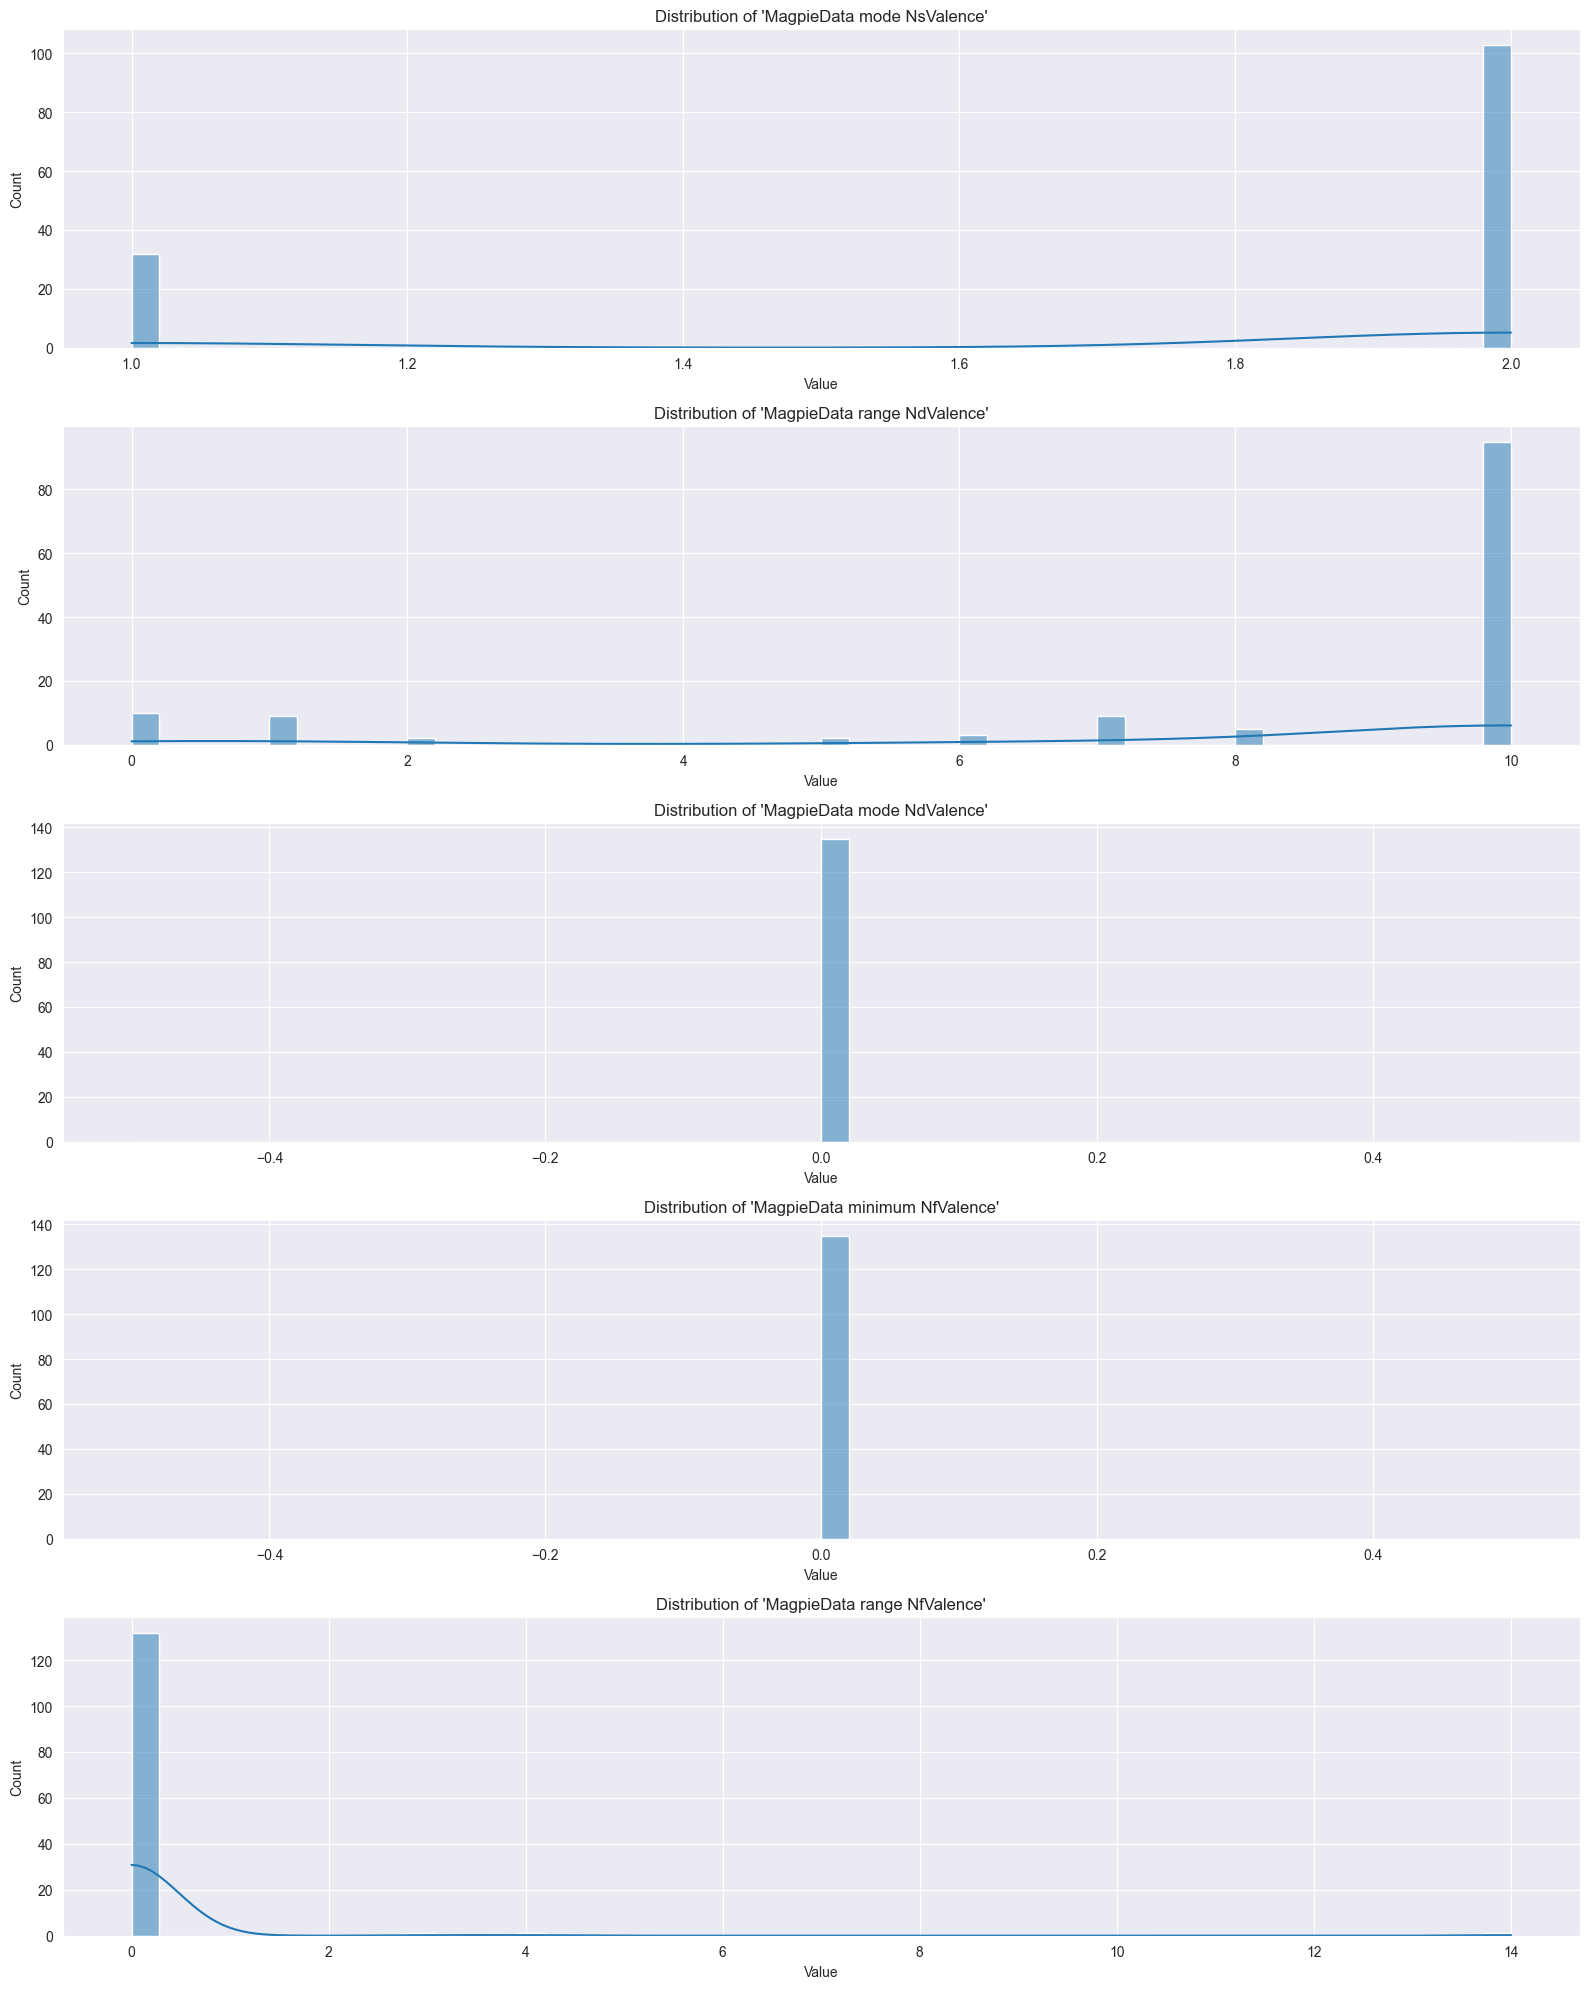

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 请根据实际路径调整
df = pd.read_csv("/Users/viewyan/Desktop/pristine_features.csv")

# 查找重复列名
duplicated_cols = df.T[df.T.duplicated()].index.tolist()

print(f"🧩 找到重复列数: {len(duplicated_cols)}")
print("🔁 重复列名样例:", duplicated_cols[:5])

# 展示前几列重复列的分布
sample_cols = duplicated_cols[:5]

plt.figure(figsize=(16, 4 * len(sample_cols)))
for i, col in enumerate(sample_cols, 1):
    plt.subplot(len(sample_cols), 1, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel("Value")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [109]:
dup_cols = df.T[df.T.duplicated()].index.tolist()

for i in range(len(dup_cols)):
    for j in range(i+1, len(dup_cols)):
        col1, col2 = dup_cols[i], dup_cols[j]
        if df[col1].equals(df[col2]):
            print(f"✅ '{col1}' 与 '{col2}' 是完全相同的列！")


✅ 'MagpieData mode NdValence' 与 'MagpieData minimum NfValence' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData mode NfValence' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData minimum NsUnfilled' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData minimum NdUnfilled' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData mode NdUnfilled' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData minimum NfUnfilled' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData mode NfUnfilled' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData minimum GSbandgap' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData minimum GSmagmom' 是完全相同的列！
✅ 'MagpieData mode NdValence' 与 'MagpieData mode GSmagmom' 是完全相同的列！
✅ 'MagpieData minimum NfValence' 与 'MagpieData mode NfValence' 是完全相同的列！
✅ 'MagpieData minimum NfValence' 与 'MagpieData minimum NsUnfilled' 是完全相同的列！
✅ 'MagpieData minimum NfValence' 与 'MagpieData minimum NdUnfilled' 是完全相同的列！
✅ 'MagpieData minimum NfValence' 与 'MagpieData mode NdUnfilled' 是

In [113]:
# 删除完全重复的列（只保留一个）
df_unique = df.loc[:, ~df.T.duplicated()]

# 看看删完后剩下多少列
print(f"✅ 删除后还剩 {df_unique.shape[1]} 列（原来是 {df.shape[1]} 列）")

# 如果你想保存一下新的 DataFrame：
df_unique.to_csv("/Users/viewyan/Desktop/pristine_features_deduplicated.csv", index=False)



✅ 删除后还剩 113 列（原来是 133 列）


In [114]:
df = pd.read_csv("/Users/viewyan/Desktop/pristine_features_deduplicated.csv")

# 查看基本结构
print("📊 样本总数:", len(df))
print("🧱 字段名:", df.columns.tolist())

# 展示前几行看看内容长啥样
print("\n🔍 前几行数据：")
print(df.head())

# 检查是否有重复行（完全重复的整行）
duplicates = df.duplicated()
print(f"\n⚠️ 重复行数: {duplicates.sum()}")

# 如果有重复，可以列出前几条看看
if duplicates.sum() > 0:
    print("\n🔁 前几条重复样本：")
    print(df[duplicates].head())

# 也可以按 mof_id 看看是否重复
dup_ids = df['mof_id'].duplicated()
print(f"\n🔁 mof_id 重复数: {dup_ids.sum()}")

# 查找重复的列
dup_cols = df.T.duplicated()

# 显示重复的列名
duplicate_columns = df.columns[dup_cols]
print(f"🧩 重复的列数: {dup_cols.sum()}")
print("🔁 重复的列名:")
print(duplicate_columns.tolist())


📊 样本总数: 135
🧱 字段名: ['mof_id', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'MagpieData 

In [115]:
df_unique.to_csv("/Users/viewyan/Desktop/pristine_features_deduplicated.csv", index=False)

# 加载结构特征
df_feat = pd.read_csv("/Users/viewyan/Desktop/pristine_features_deduplicated.csv")

# 加载目标值数据
df_all = pd.read_json("/Users/viewyan/fairchem/src/fairchem/data/odac/force_field/data_w_oms.json")

# 添加 mof_id 用于匹配
df_all["mof_id"] = df_all["name"].apply(lambda x: x.split("_w_")[0])

# 合并
merged = pd.merge(df_all, df_feat, on="mof_id", how="inner")

print("合并后的样本数：", len(merged))


合并后的样本数： 683


In [121]:
features_df = pd.read_csv("pristine_features.csv")
original_df = pd.read_json("data_w_ml.json")  # 或 data_w_oms.json，看你用哪个

# 保留 ['name', 'y'] 进行合并（或 'id'）
df = features_df.merge(original_df[['name', 'y']], left_on='mof_id', right_on='name')
df.drop(columns=['name'], inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'pristine_features.csv'

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 载入数据
df = pd.read_csv("/Users/viewyan/Desktop/pristine_features_deduplicated.csv")

# ✅ 设置目标变量
target = "y_sys"

# ✅ 筛选数值型列，排除目标列本身
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col != target]

# ✅ 自动过滤掉以下特征：
# - 标准差过低（没变化）
# - 缺失比例 > 50%
filtered_cols = []
for col in num_cols:
    if df[col].isnull().mean() > 0.5:
        continue
    if df[col].std() < 1e-3:
        continue
    filtered_cols.append(col)

print(f"🎯 可视化前有效特征数量：{len(filtered_cols)}")

# ✅ 可视化前 N 个最相关的特征（默认 N=6）
N = 6
correlations = df[filtered_cols + [target]].corr()[target].abs().sort_values(ascending=False)
top_cols = correlations.drop(target).head(N).index.tolist()

# ✅ 绘图
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(top_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"{col}\nMean={df[col].mean():.2f}, Std={df[col].std():.2f}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")

# 清除多余的 subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"📊 Top {N} Most Relevant Features to '{target}'", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

🎯 可视化前有效特征数量：110


KeyError: "['y_sys'] not in index"